In [43]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import jieba
import nltk
from nltk.corpus import stopwords
import re

# Download English stopwords if needed
nltk.download('stopwords')
eng_stopwords = set(stopwords.words('english'))

#load in Chinese stopwords
zh_stopwords = set(open('chinese_stopwords.txt', encoding='utf-8').read().split())

# Load CSVs
df_cn = pd.read_csv('combined_output.csv')
df_en = pd.read_csv('imdb_combined_output.csv')

# Preview
print(df_cn.head())
print(df_en.head())

# Chinese preprocessing
def clean_chinese(text):
    text = re.sub(r"[^\u4e00-\u9fa5]", "", str(text))  # Keep only Chinese
    words = jieba.lcut(text)
    words = [word for word in words if word not in zh_stopwords]
    return ' '.join(words)

# English preprocessing
def clean_english(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    words = [w for w in text.split() if w not in eng_stopwords]
    return ' '.join(words)

# Apply preprocessing
df_cn['clean_comment'] = df_cn['review_text'].apply(clean_chinese)
df_en['clean_comment'] = df_en['comment'].apply(clean_english)

# Combine for joint clustering
df_cn['lang'] = 'zh'
df_en['lang'] = 'en'
df_all = pd.concat([df_cn, df_en], ignore_index=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elimarx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                       title  \
0  Spider-Man: Far From Home   
1  Spider-Man: Far From Home   
2  Spider-Man: Far From Home   
3  Spider-Man: Far From Home   
4  Spider-Man: Far From Home   

                                         review_text  stars  \
0  我是一个94年的广东人，我从小身边充斥着各种蜘蛛侠作品，每天午休回家吃饭有94版蜘蛛侠动画。...      1   
1  看完后的感觉和看前担心的一样，太过于依赖于MCU以至于变成了一部最不蜘蛛侠的蜘蛛侠电影。我对...      1   
2  看得真的很难受，不是因为剧情而是因为情怀。当年的那个“能力越大，责任越大”的蜘蛛侠什么时候能...      1   
3  这是我看过最差的蜘蛛侠电影，简直就是钢铁侠2.0，这不是我从小最喜欢的那个超级英雄，我希望的...      1   
4  完全像是在过家家，根本没有一丁点超级英雄的影子。人家只想谈恋爱啦，人家只想表白啦，拯救世界什...      1   

                                         url  
0  https://movie.douban.com/review/10278279/  
1  https://movie.douban.com/review/10272061/  
2  https://movie.douban.com/review/10282408/  
3  https://movie.douban.com/review/10276920/  
4  https://movie.douban.com/review/10275699/  
     title                                            comment  rating
0  Aquaman  I rarely post reviews, but after watching this...       1
1  Aqu

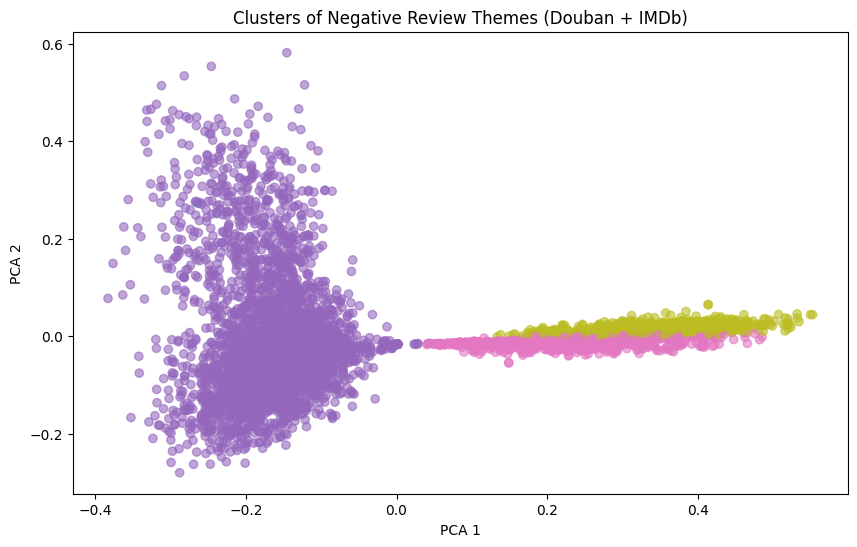

In [45]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_all['clean_comment'])

# Clustering
kmeans = KMeans(n_clusters=6, random_state=42)
df_all['cluster'] = kmeans.fit_predict(X)

# Reduce dimensions for plotting
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df_all['cluster'], cmap='tab10', alpha=0.6)
plt.title("Clusters of Negative Review Themes (Douban + IMDb)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

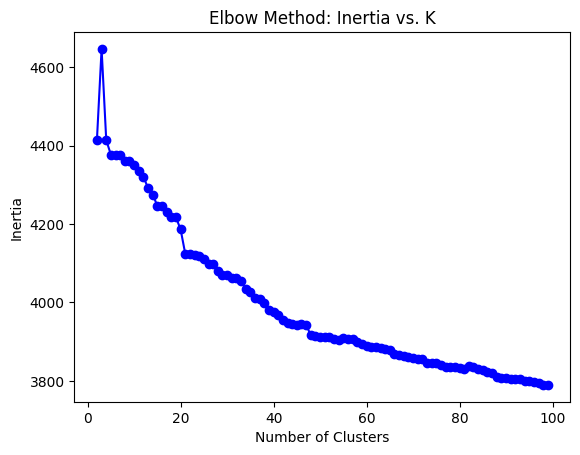

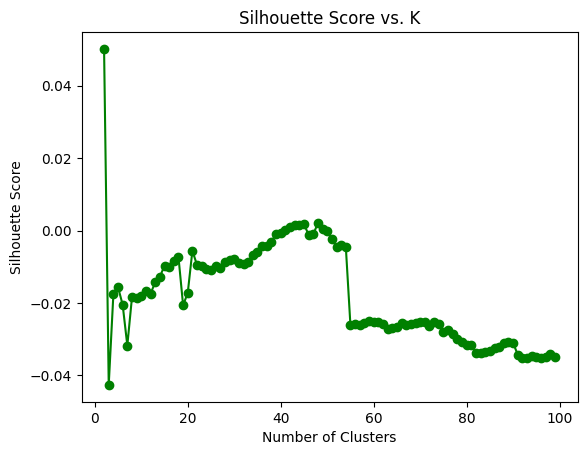

In [48]:
# Elbow plot to choose k
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []
K = range(2, 100)

for k in K:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(X)
    inertias.append(kmeans_test.inertia_)
    silhouettes.append(silhouette_score(X, kmeans_test.labels_))

plt.plot(K, inertias, 'bo-')
plt.title("Elbow Method: Inertia vs. K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

plt.plot(K, silhouettes, 'go-')
plt.title("Silhouette Score vs. K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [46]:
df_all['cluster'].value_counts()

cluster
2    3078
3     953
4     869
5       1
0       1
1       1
Name: count, dtype: int64

In [47]:
# Show sample reviews from each cluster
for cluster_id in sorted(df_all['cluster'].unique()):
    print(f"\n🔹 Cluster {cluster_id} ({df_all[df_all['cluster'] == cluster_id]['lang'].value_counts().to_dict()})")
    samples = df_all[df_all['cluster'] == cluster_id].sample(1, random_state=cluster_id)
    for _, row in samples.iterrows():
        print(f"  [{row['lang']}] {row['clean_comment'][:100]}...")


🔹 Cluster 0 ({'zh': 1})
  [zh] 本来 想着 上来 直接 低分 礼貌 先 搜 一下 长城 评分 毕竟 观影 之前 变 长城 之间 差 景甜 没想到 差值 负 对不起 只能 毫无忌惮 目光短浅 电影 看得 少书 读 少 以下 仅为 个人...

🔹 Cluster 1 ({'en': 1})
  [en] favorite academy award year really whats special movie theres plot movie boring confusing slowtheres...

🔹 Cluster 2 ({'zh': 3069, 'en': 9})
  [zh] 一颗 星是 十一年 情怀 罗素 兄弟 编剧 团队 真的 锤哥 队长 真的 非要 退休 写 铁人 最好 寡姐 结局 吊打 阿灭 惊奇 队长 这点 能耐 一群 非得 空中 接力 法师 明明 开 传送门 明...

🔹 Cluster 3 ({'en': 953})
  [en] keep book plot characters background mind heart leave story film doesnt follow book anyway character...

🔹 Cluster 4 ({'en': 869})
  [en] jurassic park tension story established like runaway train two adults two kids movie held breathtaki...

🔹 Cluster 5 ({'zh': 1})
  [zh] 快 跑 离开 森林 海洋 全程 迷惑 剧情 明 知道 是因为 跑 地方 祸害 不能 直接 痛痛快快 一架 男主到 结尾 终于 回应 问题 终于 知道 不能 逃避 庇护 家人 真的 一脸 问号 保护 家...
